In [1]:
import os
import json
import pandas as pd
import numpy as np
import json

from matplotlib import pyplot as plt
import seaborn as sb

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [2]:
sb.set_style("darkgrid")
sb.set_context("paper",  font_scale = 1,
               rc={
                   "grid.linewidth": 2.5,
                   'axes.labelsize': 24,
                   "axes.titlesize": 26,
                   "legend.fontsize": 24.0,
                   'lines.linewidth': 2.5,
                   'xtick.labelsize': 22.0,
                   'ytick.labelsize': 22.0,
               })

In [3]:
opt_cost_dict = {
     0: 22,  1: 56,  2: 56,  3: 60,  4: 22,  5:  54,  6: 27,  7: 12,  8: 14,  9: 120,
    10: 42, 11: 35, 12: 28, 13: 32, 14: 24, 15:  15, 16: 24, 17: 45, 18: 90, 19:  60,
    20: 10, 21: 40, 22: 28, 23: 54, 24: 72, 25: 108, 26: 14, 27: 80, 28: 60, 29:  20
}

exp_dir = '/home/biedenka/git/rl-plan'

opt_pols = {}
for inst in range(30):
    with open(os.path.join(exp_dir, 'artifical-benchmarks', 'train', 'instance%d' % inst, 'optimal.json')) as fh:
        opt_pol = json.load(fh)[1:]
#     print('Instance %d' % inst)
#     print(opt_pol)
#     print(inst, len(opt_pol))
#     print()
    opt_pols[inst] = opt_pol
    opt_cost_dict[inst] = len(opt_pol)


data_dir = "/home/biedenka/git/rl-plan/experiments/baseline_data/"
static_cost = {}
random_cost = {}
round_robin_cost = {}
rl_cost = {}

static_traj = {}
random_traj = {}
round_robin_traj = {}
rl_traj = {}

print('Loading Data')
for instance in range(30):
    with open(os.path.join(data_dir, 'train', 'instance-%d-random.json' % instance), 'r') as fh:
        data = json.load(fh)
        random_cost[instance] = (data['mean'], data['stdev'])
        random_traj[instance] = data['trajectories']

    with open(os.path.join(data_dir, 'train', 'instance-%d-rl-25-wide.json' % instance), 'r') as fh:
        data = json.load(fh)
        rl_cost[instance] = (data['mean'], data['stdev'])
        rl_traj[instance] = data['trajectories']
    
    for act in [0, 1]:
        if act not in static_cost:
            static_cost[act] = {}
            static_traj[act] = {}
            round_robin_cost[act] = {}
            round_robin_traj[act] = {}
        with open(os.path.join(data_dir, 'train', 'instance-%d-static-action-%d.json' % (instance, act)), 'r') as fh:
            data = json.load(fh)
            static_cost[act][instance] = (data['mean'], data['stdev'])
            static_traj[act][instance] = data['trajectories']
            
        for switch in range(1, 25):
            if switch not in round_robin_cost[act]:
                round_robin_cost[act][switch] = {}
                round_robin_traj[act][switch] = {}
            with open(os.path.join(data_dir, 'train', 'instance-%d-rr-%d-act%d.json' % (instance, switch, act)), 'r') as fh:
                data = json.load(fh)
                round_robin_cost[act][switch][instance] = (data['mean'], data['stdev'])
                round_robin_traj[act][switch][instance] = data['trajectories']

static_cost['oracle_portfolio'] = {}
static_traj['oracle_portfolio'] = {}
for i in range(len(opt_cost_dict.keys())):
    better_act = 0 if static_cost[0][i] > static_cost[1][i] else 1
    static_cost['oracle_portfolio'][i] = static_cost[better_act][i]
    static_traj['oracle_portfolio'][i] = static_traj[better_act][i]
print('Done')

Loading Data
Done


In [4]:
def plot(plot_bsf=True, old=False, lay=[5, 10, 20], uni=[20, 40], exp=[1, 2]):
    for units in uni:
        for layers in lay:

            fig = plt.figure(figsize=(15, 5), dpi=100)
            ax = plt.gca()
            for exploration in exp:
                
                exp_dir = os.path.join(os.path.sep, 'mhome', 'biedenka',
                                       'rl-plan-tmp', 'experiments', 'toy-benchmarks',
                                       'old_feats_wide_short_full_train_set_%d-%d-%d' % (
                                           layers, units, exploration))
                if exploration == 1:
                    print('#'*80)
                    print(exp_dir)
                    print('#'*80)
                try:
                    df = pd.read_csv(os.path.join(exp_dir, 'scores.txt'), sep='\t',
                                     index_col=None)
                except Exception as e:
                    print(e)

                if not plot_bsf:
                    plt.step(df.steps, df['mean'] * -1, where='mid', label='mean',
                             alpha=0.25)
                    # plt.step(df.steps, df['min'] * -1, where='mid', label='worst')
                    plt.step(df.steps, df['median'] * -1, where='mid', label='median',
                             alpha=0.25)
                    plt.xlabel('#steps')
                else:
                    mean = df['mean']
                    mead = df['median']
                    me, md = [], []
                    for idx, v in enumerate(zip(mean, mead)):
                        if idx == 0: 
                            me.append(v[0])
                            md.append(v[1])
                            continue
                        if v[0] > me[-1]:
                            me.append(mean[idx])
                            md.append(mead[idx])
                        else:
                            me.append(me[-1])
                            md.append(md[-1])
                    # additional +1 as reward is misaligned by 1
                    data = (np.array(me) +1) * -1
                    plt.step(df.steps/1000, (np.array(me) +1) * -1, where='post')  # ,
#                              label='learned-bsf')
                    print('Final learned', data[-1])
                    #  plt.step(df.steps/1000, np.array(md) * -1, where='post',
                    #           label='median-bsf')

            ax.set_title('TRAIN')
            ax.set_ylabel('Plan-Cost')
            if plot_bsf:
                opt_mean = np.mean(list(opt_cost_dict.values()))
                static_0 = -np.mean(list(static_cost[0].values()))
                static_1 = -np.mean(list(static_cost[1].values()))
                static_o = -np.mean(list(static_cost['oracle_portfolio'].values()))
                random_mean, random_std = np.mean([-x[0] for x in random_cost.values()]), np.std([x[1] for x in random_cost.values()])
                ssteps = [0, 500]
                plt.plot(ssteps, [opt_mean, opt_mean],
                         ls='--', label='optimal-mean')
                ssteps[0] = 0  # np.sum(list(static_cost[0].values()))/1000
                plt.plot(ssteps, [static_0, static_0],
                         ls='--', label='static-0-mean')
                ssteps[0] = 0  # np.sum(list(static_cost[1].values()))/1000
                plt.plot(ssteps, [static_1, static_1],
                         ls='--', label='static-1-mean')
                ssteps[0] = 0
                plt.plot(ssteps, [static_o, static_o],
                         ls='--', label='oracle-portfolio')
                plt.plot(ssteps, [random_mean, random_mean],
                         ls='--', label='random-mean', c='gray')
                plt.fill_between(ssteps, random_mean + random_std,
                                 random_mean - random_std, alpha=0.25,
                                 color='gray')

                for act in [0]:  # [0, 1]:
                    for switch in [11]:  # [3,4,5,6,7]:
                        v = np.mean([-x[0] for x in round_robin_cost[act][switch].values()])
                        plt.plot(ssteps, [v, v],
                                 label = 'rr-%d-%d' % (act, switch),
                                 ls = '--')
                plt.ylim([0, 600])
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                          fancybox=True, shadow=True, ncol=4)
                plt.xlabel('#steps [k]')
                plt.xlim([0, 500])
            else:
                plt.ylim([0, 1500])
                plt.xlim([0, 500_000])
                plt.xlabel('#steps')
            plt.show()
            print()
            print()

In [5]:
def plot_means(plot_bsf=True, old=False, lay=[5, 10, 20], uni=[20, 40], exp=[1, 2],
               quantile=False):
    for units in uni:
        for layers in lay:

            fig = plt.figure(figsize=(15, 5), dpi=100)
            ax = plt.gca()
            dfs = []
            for exploration in exp:
                
                exp_dir = os.path.join(os.path.sep, 'mhome', 'biedenka',
                                       'rl-plan-tmp', 'experiments', 'toy-benchmarks',
                                       'old_feats_wide_short_full_train_set_%d-%d-%d' % (
                                           layers, units, exploration))
                if exploration == 1:
                    print('#'*80)
                    print(exp_dir)
                    print('#'*80)
                try:
                    df = pd.read_csv(os.path.join(exp_dir, 'scores.txt'), sep='\t',
                                     index_col=None)
                    dfs.append(df)
                except Exception as e:
                    print(e)

            if not plot_bsf:
                frame = pd.concat(dfs)
                if quantile:
                    df = frame.groupby(frame.index).quantile(q=.5)
                    dsu = frame.groupby(frame.index).quantile(q=.75)
                    dsl = frame.groupby(frame.index).quantile(q=.25)
                    u = dsl['mean'] * -1
                    l = dsu['mean'] * -1
                    um = dsl['median'] * -1
                    lm = dsu['median'] * -1
                else:
                    df = frame.groupby(frame.index).mean()
                    ds = frame.groupby(frame.index).std()
                    u = df['mean'] * -1 + ds['mean']
                    l = df['mean'] * -1 - ds['mean']
                    um = df['median'] * -1 + ds['median']
                    lm = df['median'] * -1 - ds['median']
                plt.step(df.steps, df['mean'] * -1, where='post',
                         label='mean', color='b')
                plt.fill_between(df.steps, u, l, step='post', color='b', alpha=0.25)
                plt.step(df.steps, df['median'] * -1, where='post',
                         label='median', color='orange')
                plt.fill_between(df.steps, um, lm, step='post', color='orange', alpha=0.25)
                plt.xlabel('#steps')
            else:
                mes = []
                stps = []
                ml = -1
                for df in dfs:
                    mean = df['mean']
                    mead = df['median']
                    steps = df['steps']
                    me, md = [], []
                    stp = []
                    for idx, v in enumerate(zip(mean, mead, steps)):
                        if idx == 0: 
                            me.append(v[0])
                            md.append(v[1])
                            stp.append(v[2])
                            continue
                        if v[0] > me[-1]:
                            me.append(mean[idx])
                            md.append(mead[idx])
                            stp.append(steps[idx])
                        else:
                            me.append(me[-1])
                            md.append(md[-1])
                            stp.append(steps[idx])
                    if len(me) > ml:
                        ml = len(me)
                    mes.append(me)
                    stps.append(stp)
                for idx in range(len(mes)):
                    while len(mes[idx]) < ml:
                        mes[idx].append(np.nan)
                        stps[idx].append(np.nan)
                
                if quantile:
                    m = -np.nanquantile(mes, q=.5, axis=0)
                    u = -np.nanquantile(mes, q=.25, axis=0)
                    l = -np.nanquantile(mes, q=.75, axis=0)
                else:
                    m = -np.nanmean(mes, axis=0)
                    u = m + np.nanstd(mes, axis=0)
                    l = m - np.nanstd(mes, axis=0)
                stps = np.nanmean(stps, axis=0) / 1000
                plt.step(stps, m, where='post',
                         label='learned-bsf')

                plt.fill_between(stps, u, l, step='post', color='b', alpha=0.25)
                print('Final learned', m[-1])
                #  plt.step(df.steps/1000, np.array(md) * -1, where='post',
                #           label='median-bsf')

            ax.set_title('TRAIN')
            ax.set_ylabel('Plan-Cost')
            if plot_bsf:
                opt_mean = np.mean(list(opt_cost_dict.values()))
                static_0 = -np.mean(list(static_cost[0].values()))
                static_1 = -np.mean(list(static_cost[1].values()))
                static_o = -np.mean(list(static_cost['oracle_portfolio'].values()))
                random_mean, random_std = np.mean([-x[0] for x in random_cost.values()]), np.std([x[1] for x in random_cost.values()])
                ssteps = [0, 500]
                plt.plot(ssteps, [opt_mean, opt_mean],
                         ls='--', label='optimal-mean')
                ssteps[0] = 0  # np.sum(list(static_cost[0].values()))/1000
                plt.plot(ssteps, [static_0, static_0],
                         ls='--', label='static-0-mean')
                ssteps[0] = 0  # np.sum(list(static_cost[1].values()))/1000
                plt.plot(ssteps, [static_1, static_1],
                         ls='--', label='static-1-mean')
                ssteps[0] = 0
                plt.plot(ssteps, [static_o, static_o],
                         ls='--', label='oracle-portfolio')
                plt.plot(ssteps, [random_mean, random_mean],
                         ls='--', label='random-mean', c='gray')
                plt.fill_between(ssteps, random_mean + random_std,
                                 random_mean - random_std, alpha=0.25,
                                 color='gray')

                for act in [0]:  # [0, 1]:
                    for switch in [11]:  # [3,4,5,6,7]:
                        v = np.mean([-x[0] for x in round_robin_cost[act][switch].values()])
                        plt.plot(ssteps, [v, v],
                                 label = 'rr-%d-%d' % (act, switch),
                                 ls = '--')
                plt.ylim([0, 600])
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                          fancybox=True, shadow=True, ncol=4)
                plt.xlabel('#steps [k]')
                plt.xlim([0, 500])
            else:
                plt.ylim([0, 1_000])
                plt.xlim([0, 500_000])
                plt.xlabel('#steps')
            plt.show()
            print()
            print()

<BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR>
# Results over 10 seeds

#### Plot Incumbent Performance

##### Plots using mean +- stdev
plot_means(plot_bsf=True, old=True, lay=[2], uni=[75, 150, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=False)
           
           
           
##### Plots using Quartiles:           

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_short_full_train_set_2-75-1
################################################################################
Final learned 44.31666666666666


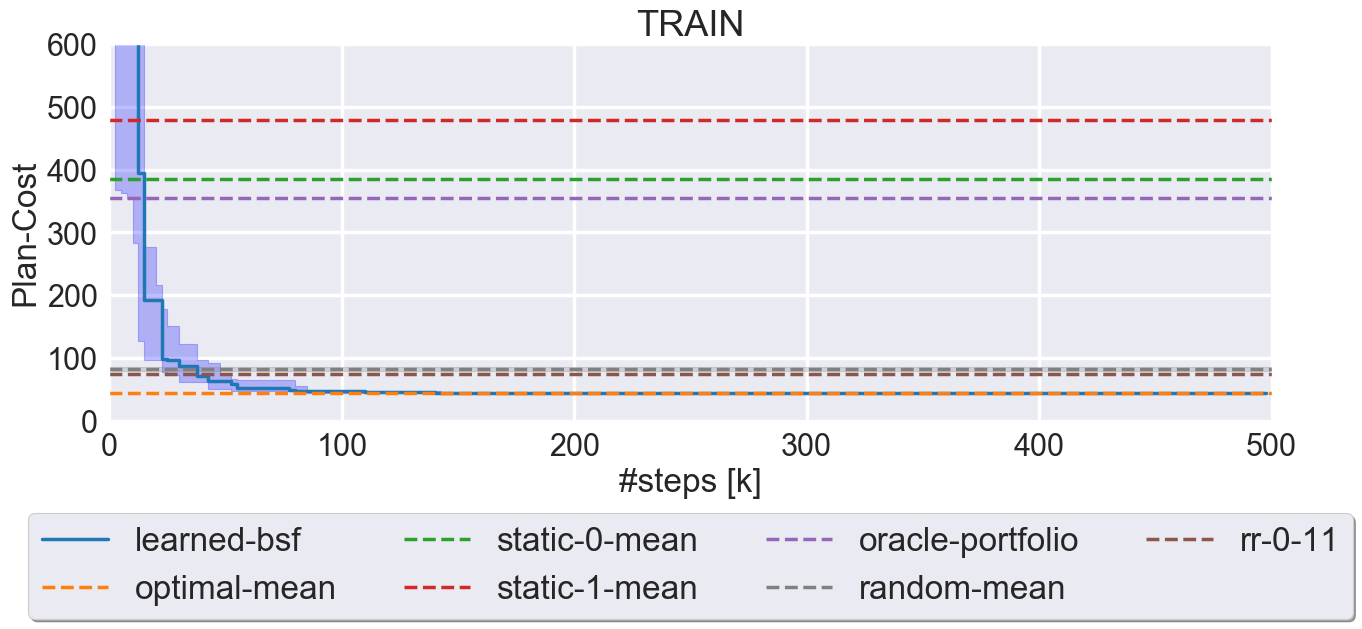



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_short_full_train_set_2-150-1
################################################################################
Final learned 44.13333333333333


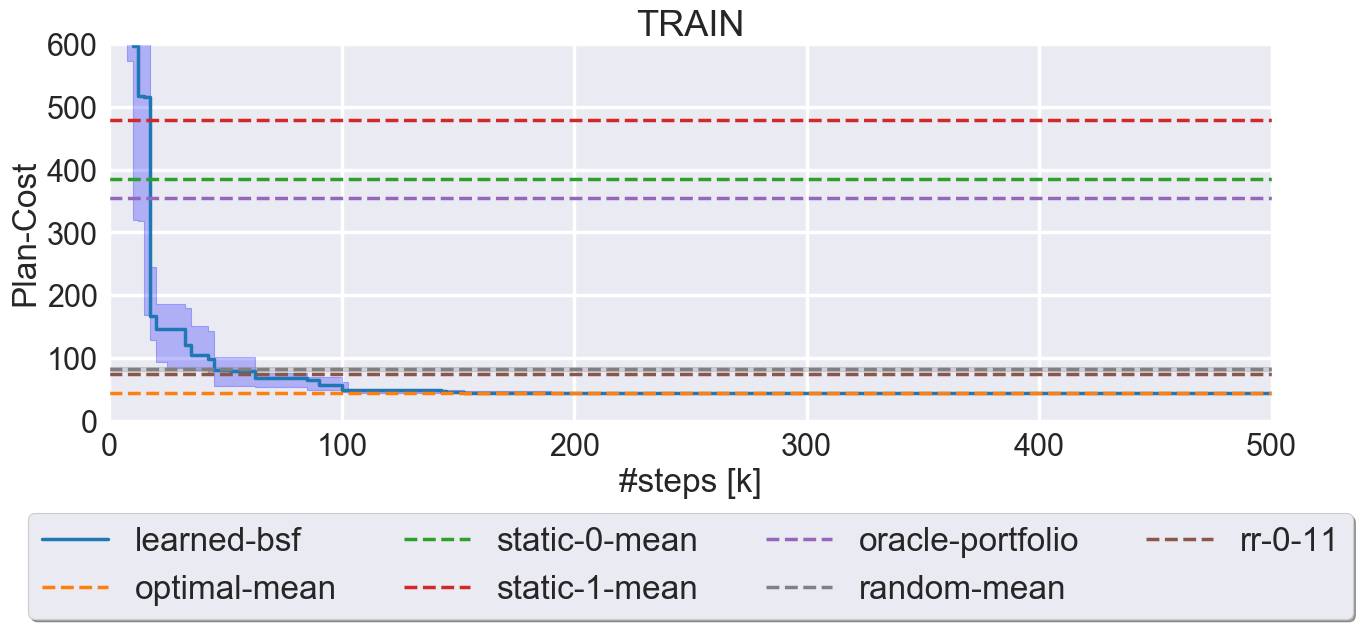



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_short_full_train_set_2-200-1
################################################################################
Final learned 44.13333333333333


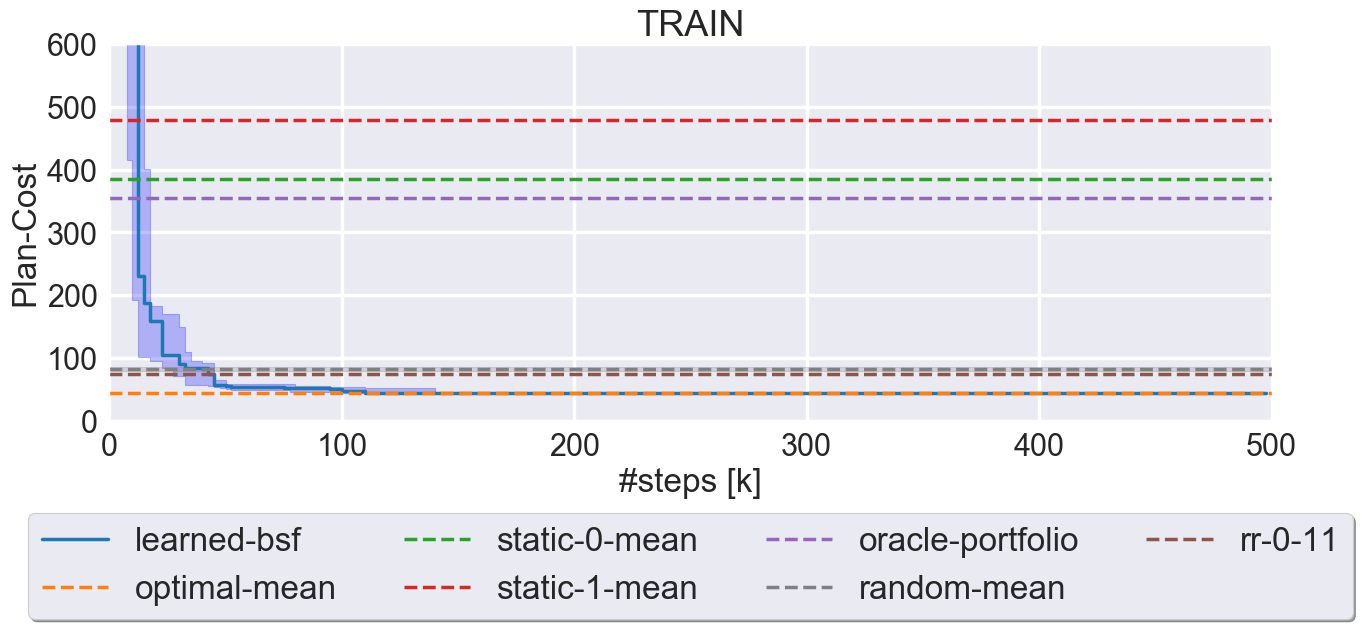

In [6]:
plot_means(plot_bsf=True, old=True, lay=[2], uni=[75, 150, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=True)

#### Plot RL Performance

##### Plots using mean +- stdev
plot_means(plot_bsf=False, old=True, lay=[2], uni=[75, 150, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=False)
           
           
           
##### Plots using Quartiles:           

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_short_full_train_set_2-75-1
################################################################################


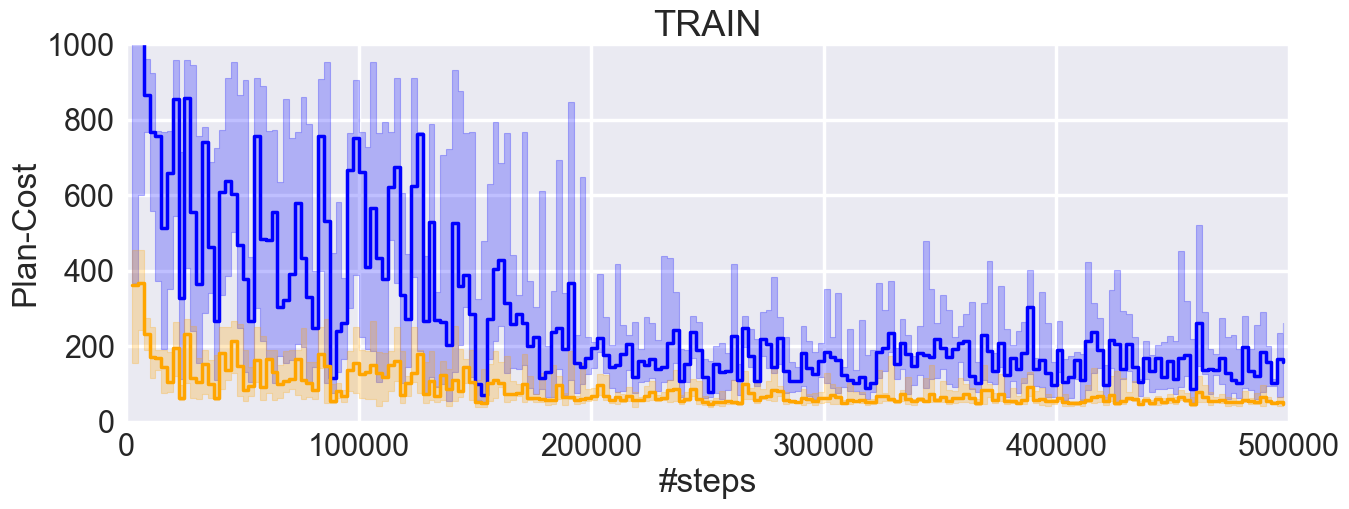



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_short_full_train_set_2-150-1
################################################################################


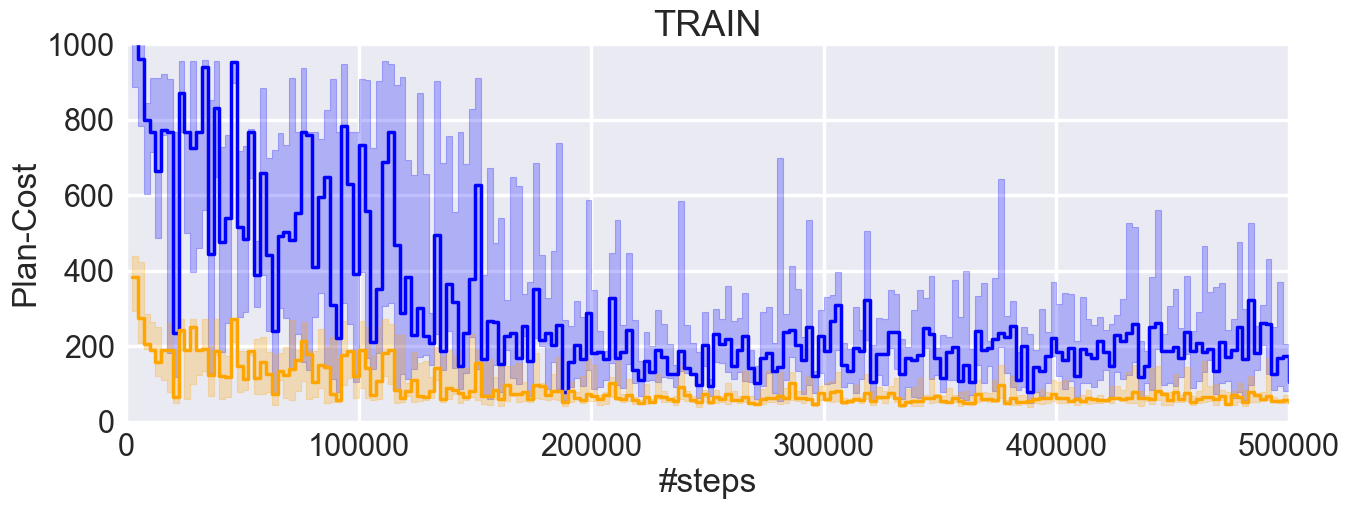



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_short_full_train_set_2-200-1
################################################################################


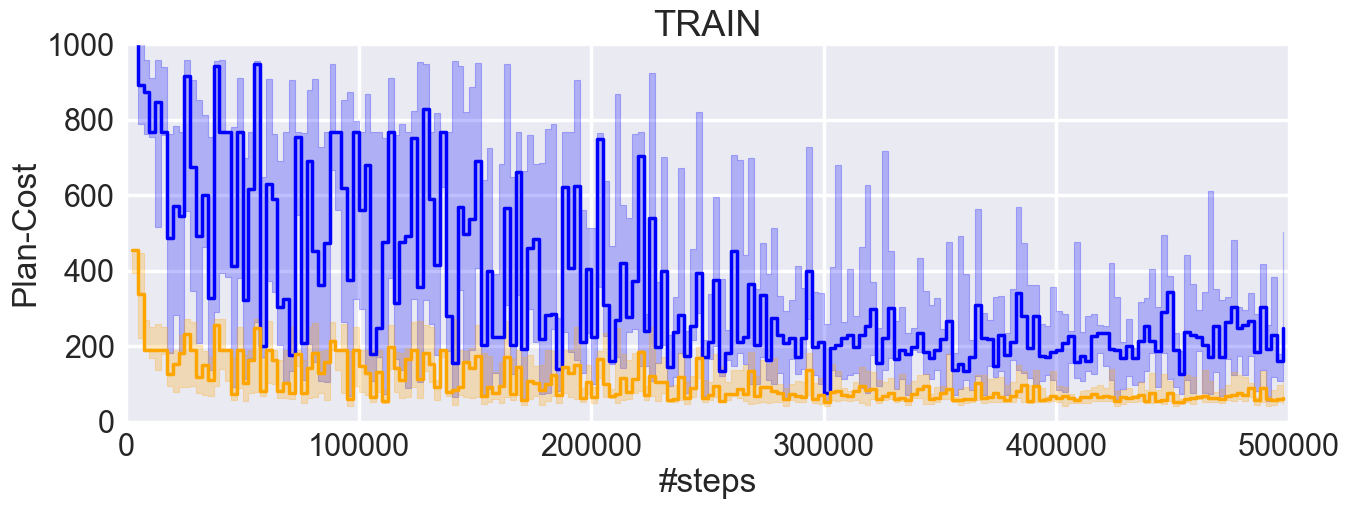

In [7]:
plot_means(plot_bsf=False, old=True, lay=[2], uni=[75, 150, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=True)

<BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR>
## Plotting individual runs
<BR>

#### OLD FEATS
##### Very Wide Nets

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_short_full_train_set_2-75-1
################################################################################
Final learned 43.13333333333333
Final learned 43.13333333333333
Final learned 43.13333333333333
Final learned 43.23333333333333
Final learned 43.46666666666667
Final learned 43.13333333333333
Final learned 43.56666666666667
Final learned 43.4
Final learned 44.93333333333333
Final learned 43.4


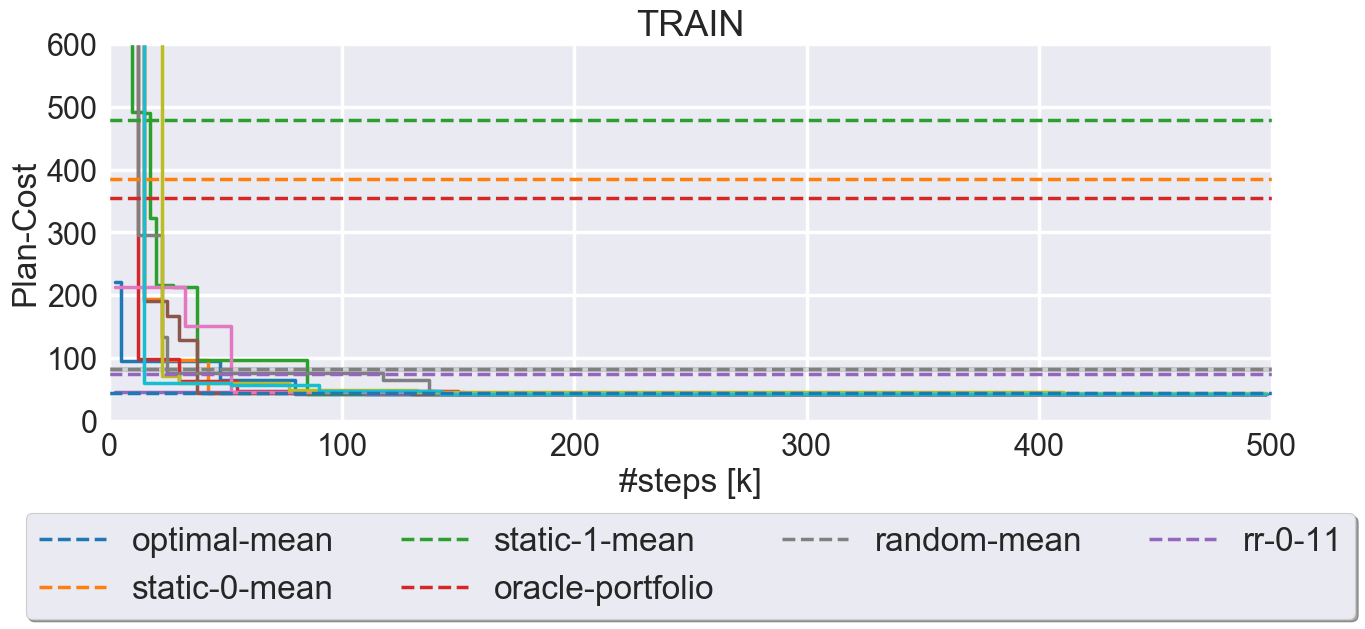



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_short_full_train_set_2-150-1
################################################################################
Final learned 43.13333333333333
Final learned 44.06666666666667
Final learned 43.13333333333333
Final learned 43.13333333333333
Final learned 43.2
Final learned 43.26666666666666
Final learned 43.13333333333333
Final learned 44.5
Final learned 43.43333333333333
Final learned 43.13333333333333


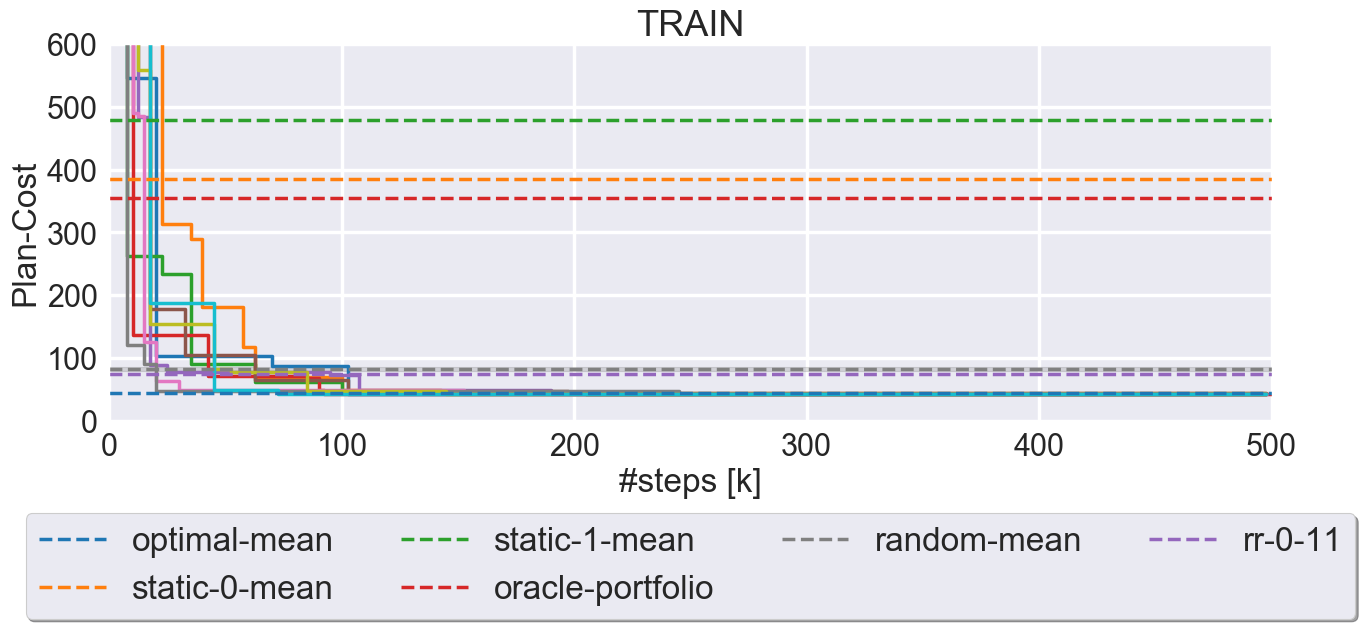



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_short_full_train_set_2-200-1
################################################################################
Final learned 43.13333333333333
Final learned 43.46666666666667
Final learned 43.13333333333333
Final learned 43.13333333333333
Final learned 43.13333333333333
Final learned 43.13333333333333
Final learned 46.16666666666666
Final learned 43.13333333333333
Final learned 43.56666666666667
Final learned 43.13333333333333


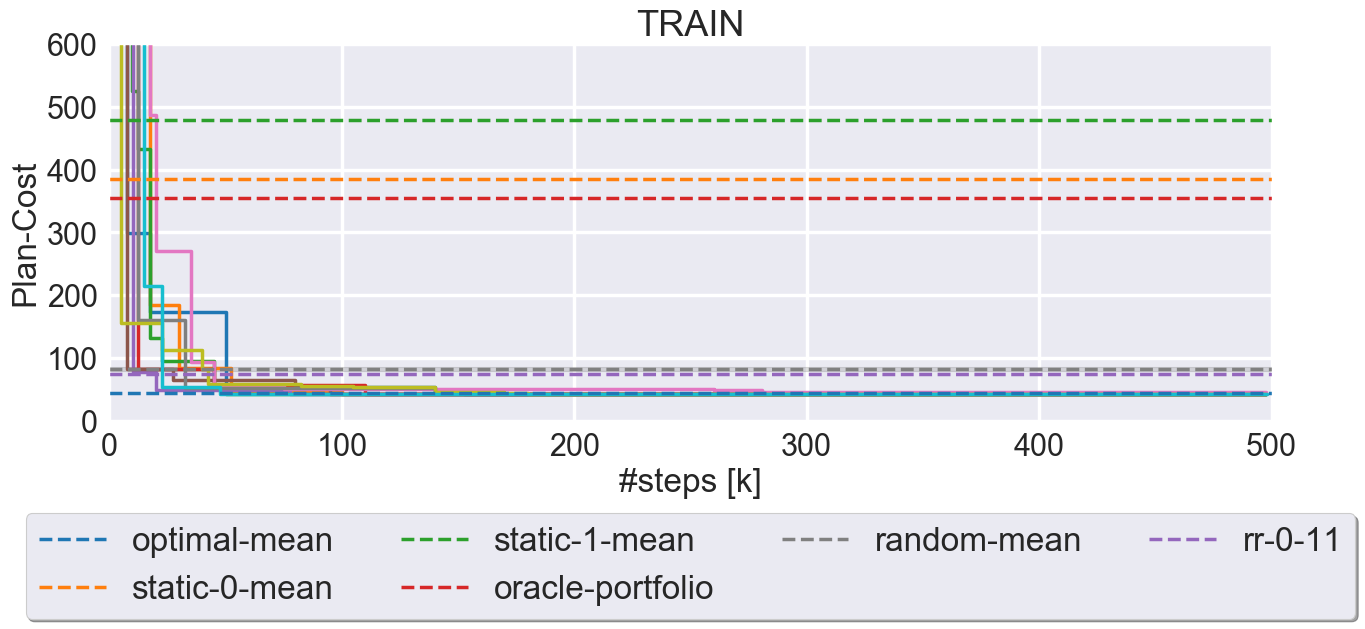

In [8]:
plot(old=True, lay=[2], uni=[75, 150, 200], exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_short_full_train_set_2-75-1
################################################################################


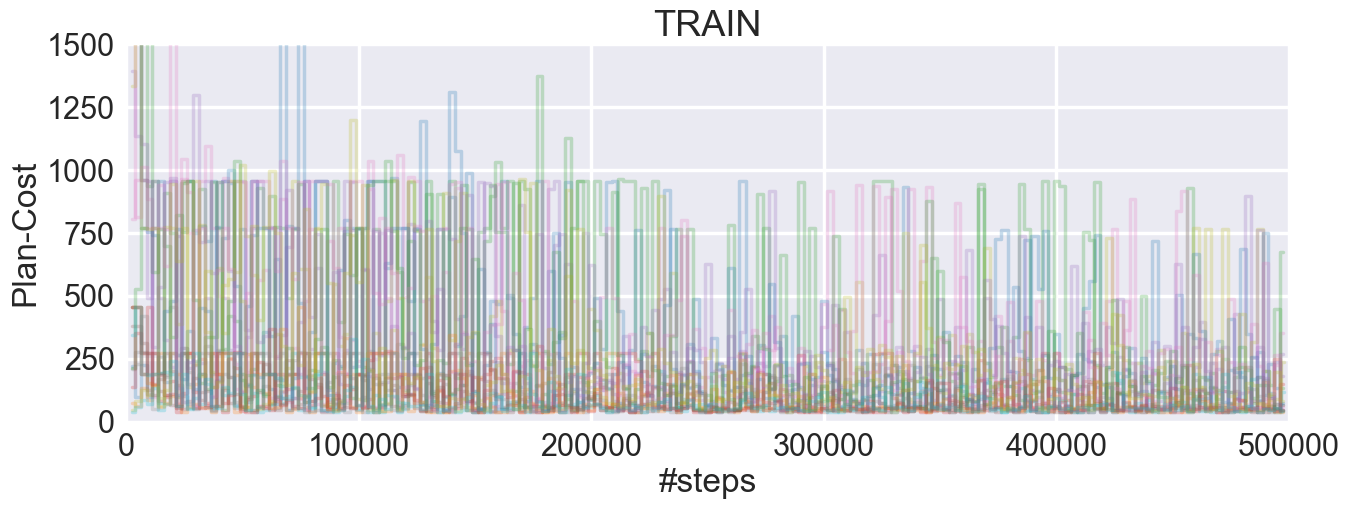



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_short_full_train_set_2-150-1
################################################################################


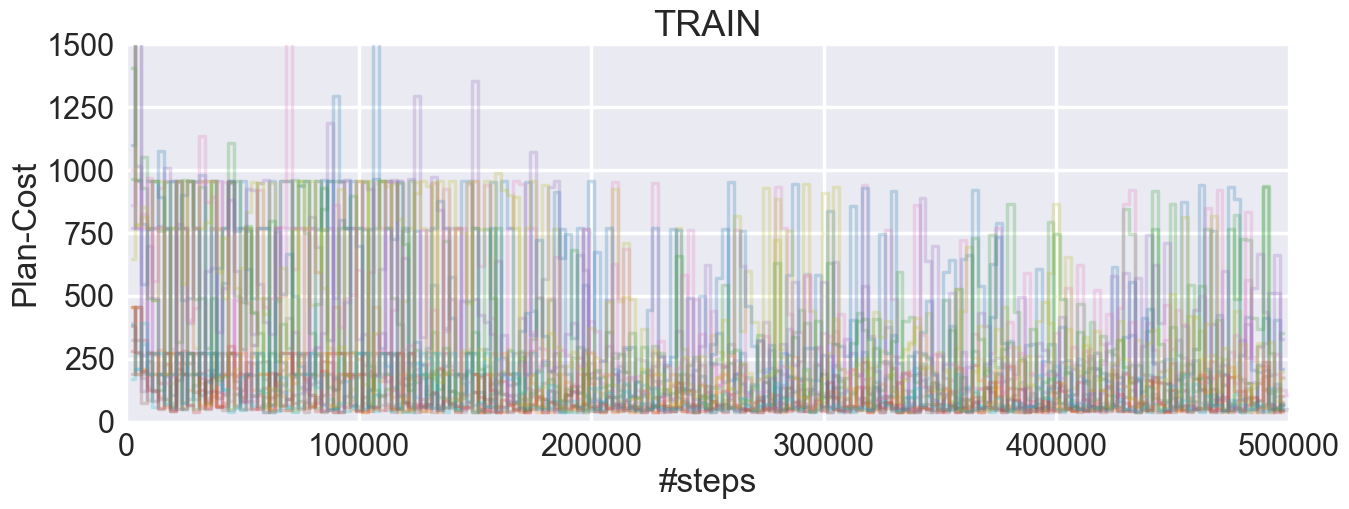



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_short_full_train_set_2-200-1
################################################################################


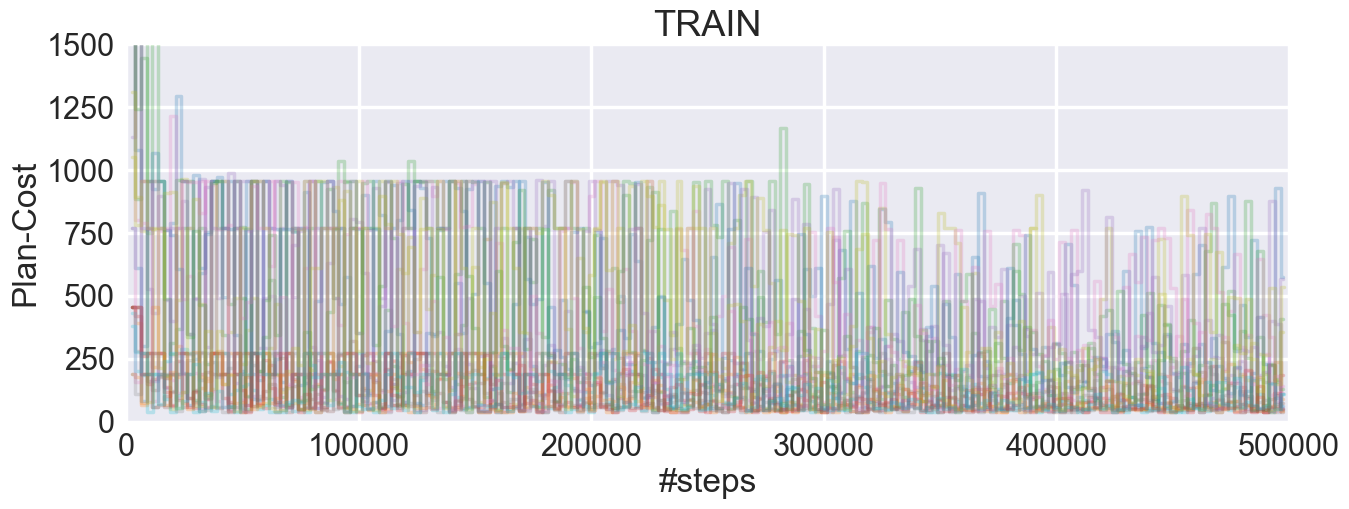

In [9]:
plot(plot_bsf=False, old=True, lay=[2], uni=[75, 150, 200], exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])